In [2]:
!pip install  --quiet langgraph
!pip install  --quiet langchain-google-genai
!pip install --quiet langchain
!pip install --quiet tavily-python
!pip install --quiet langchain_community
!pip install --quiet wikipedia
!pip install --quiet google-generativeai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.3/119.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 73.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [41]:
import operator
from datetime import datetime
from google.colab import userdata
from IPython.display import Image, display, Markdown
import textwrap
import os
import getpass

from typing import Any, Annotated, List, TypedDict
from pydantic import BaseModel, Field

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import get_buffer_string, AIMessage, HumanMessage, SystemMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.document_loaders import WikipediaLoader

from langgraph.graph import MessagesState
from langgraph.graph.state import StateGraph, END, START
from langgraph.checkpoint.memory import MemorySaver


In [4]:
config = {"temperature": 0.2,
          "top_p":0.95,
          "top_k":64,
          "max_outout_tokens":5000,
          "response_mime_type": "text/plain",
        }

model = ChatGoogleGenerativeAI(model="gemini-1.5-flash",
                              api_key=userdata.get('GOOGLE_API_KEY'),
                              **config
                              )

model.invoke("What is 2+2?").content

'2 + 2 = 4 \n'

In [5]:
def to_markdown(text)-> Markdown:
    text : str = text.replace("•", "  *")
    return Markdown(textwrap.indent(text, "> ", predicate=lambda _: True))

In [16]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("TAVILY_API_KEY")

TAVILY_API_KEY: ··········


In [6]:
class SubTopicList(BaseModel):
  subtopics: List[str] = Field(description="The subtopics for which podcast is generated")

class KeywordList(BaseModel):
  keywords: List[str] = Field(description="The keywords for which podcast is generated")

class PlanningState(TypedDict):
  topic: str
  keywords: list[str]
  subtopics: list[str]

In [7]:
def keyword_generator_node(state: PlanningState):
  """Graph node that uses AI to generate at least 5 keywords"""
  topic: str = state["topic"]
  prompt: str = f"""You are experienced podcast analyzer. You have to generate at least
                5 keywords for the topic {topic}.
                """
  structure_llm = model.with_structured_output(KeywordList)
  response: KeywordList = structure_llm.invoke(prompt)
  return {"keywords": response.keywords}

def subtopic_generator_node(state: PlanningState):
  """Graph node that uses AI to generate at least 5 subtopics"""
  topic: str = state["topic"]
  prompt: str = f"""You are experienced podcast analyzer. You have to generate at least
                5 subtopics to make a podcast about the following topic {topic}.
                """
  structure_llm = model.with_structured_output(SubTopicList)
  response: SubTopicList = structure_llm.invoke(prompt)
  return {"subtopics": response.subtopics}

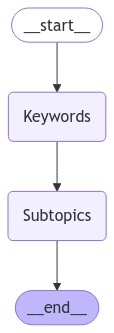

In [8]:
planning_builder: StateGraph = StateGraph(PlanningState)

planning_builder.add_node("Keywords", keyword_generator_node)
planning_builder.add_node("Subtopics", subtopic_generator_node)

planning_builder.add_edge(START, "Keywords")
planning_builder.add_edge("Keywords", "Subtopics")
planning_builder.add_edge("Subtopics", END)

planning_agent = planning_builder.compile()

display(Image(planning_agent.get_graph(xray=1).draw_mermaid_png()))

In [9]:
planning_agent.invoke({"topic": "What is attention in human cognition?"})

{'topic': 'What is attention in human cognition?',
 'keywords': ['attention',
  'human cognition',
  'consciousness',
  'awareness',
  'focus',
  'selective attention',
  'cognitive processes',
  'brain function',
  'perception',
  'memory'],
 'subtopics': ['What is attention?',
  'Types of attention',
  'Neural mechanisms of attention',
  'Attention and memory',
  'Attention and perception',
  'Attention disorders']}

In [43]:
class InterviewState(MessagesState):
  topic: str #topic of podcast
  max_num_turns: int #number of turns in the conversation
  context: Annotated[list, operator.add] #source documents
  section: str #section transcript
  sections: list #final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
  search_query: str = Field(description="The search query for retrieval")

In [44]:
structure_llm = model.with_structured_output(SearchQuery)

In [51]:
question_instructions = """You are the host of a popular podcast and you are tasked with interviewing an expert to learn about a specific topic.
Your goal is boil down to interesting and specific insights related to your topic.
1. Interesting: Insights that people will find surprising or non-obvious.
2. Specific: Insights that avoid generalities and include specific examples from the expert.
Here is your topic of focus and set of goals: {topic}
Begin by introducing the topic that fits your goals, and then ask your question.
Continue to ask questions to drill down and refine your understanding of the topic.
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help"
Remember to stay in character throughout your response"""

def generate_question(state: InterviewState):
    """ Node to generate a question """
    # Get state
    topic = state["topic"]
    messages = state["messages"]
    # Generate question
    system_message = question_instructions.format(topic=topic)
    question = model.invoke([SystemMessage(content=system_message)]+messages)
    # Write messages to state
    return {"messages": [question]}


search_instructions = SystemMessage(content=f"""You will be given a conversation between a host of a popular podcast and an expert.
Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
First, analyze the full conversation.
Pay particular attention to the final question posed by the analyst.
Convert this final question into a well-structured web search query""")

def search_web(state: InterviewState):
    """ Retrieve docs from web search """
    # Search query
    search_query = structure_llm.invoke([search_instructions]+state['messages'])
    # Search
    tavily_search = TavilySearchResults(max_results = 3)
    search_docs = tavily_search.invoke(search_query.search_query)
     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )
    return {"context": [formatted_search_docs]}


def search_wikipedia(state: InterviewState):
    """ Retrieve docs from wikipedia """
    # Search query
    search_query = structure_llm.invoke([search_instructions]+state['messages'])
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query,
                                  load_max_docs=2).load()
     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )
    return {"context": [formatted_search_docs]}

answer_instructions = """You are an expert being interviewed by a popular podcast host.
Here is the analyst's focus area: {topic}.
Your goal is to answer a question posed by the interviewer.
To answer the question, use this context:
{context}
When answering questions, follow these steps
1. Use only the information provided in the context.
2. Do not introduce outside information or make assumptions beyond what is explicitly stated in the context.
3. The context includes sources on the topic of each document.
4. Make it interesting."""

def generate_answer(state: InterviewState):
  """ Node to answer a question """
  # Get state
  topic = state["topic"]
  messages = state["messages"]
  context = state["context"]
  # Answer question
  system_message = answer_instructions.format(topic=topic, context=context)
  answer = model.invoke([SystemMessage(content=system_message)]+messages)
  # Name the message as coming from the expert
  answer.name = "expert"
  # Append it to state
  return {"messages": [answer]}

def save_podcast(state: InterviewState):
  """ save_podcast """
  # Get messages
  messages = state["messages"]
  # Convert interview to a string
  interview = get_buffer_string(messages)
  # Save to interviews key
  return {"section": interview}

def route_messages(state: InterviewState, name: str="expert"):
  """ Route between question and answer """
  # Get messages
  messages = state["messages"]
  max_num_turns = state.get('max_num_turns',2)
  # Check the number of expert answers
  num_responses = len(
      [m for m in messages if isinstance(m, AIMessage) and m.name == name]
  )
  # End if expert has answered more than the max turns
  if num_responses >= max_num_turns:
      return 'Save podcast'
  # This router is run after each question - answer pair
  # Get the last question asked to check if it signals the end of discussion
  last_question = messages[-2]
  if "Thank you so much for your help" in last_question.content:
      return 'Save podcast'
  return "Host question"

section_writer_instructions = """You are an expert technical writer.
Your task is to create an interesting, easily digestible section of a podcast based on an interview.
1. Analyze the content of the interview
2. Create a script structure using markdown formatting
3. Make your title engaging based upon the focus area of the analyst:
{focus}
4. For the conversation:
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Mention turns of "Interviewer" and "Expert"
- Aim for approximately 1000 words maximum
5. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: InterviewState):
    """ Node to answer a question """
    # Get state
    section = state["section"]
    topic = state["topic"]
    system_message = section_writer_instructions.format(focus=topic)
    section_res = model.invoke(system_message + f"Use this source to write your section: {section}")
    # Append it to state
    return {"sections": [section_res.content]}

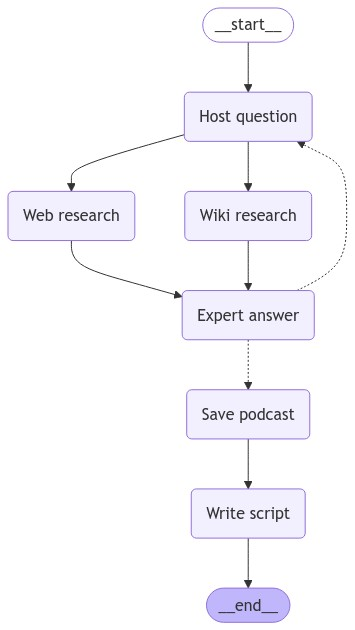

In [52]:
# Add nodes and edges
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("Host question", generate_question)
interview_builder.add_node("Web research", search_web)
interview_builder.add_node("Wiki research", search_wikipedia)
interview_builder.add_node("Expert answer", generate_answer)
interview_builder.add_node("Save podcast", save_podcast)
interview_builder.add_node("Write script", write_section)

# Flow
interview_builder.add_edge(START, "Host question")
interview_builder.add_edge("Host question", "Web research")
interview_builder.add_edge("Host question", "Wiki research")
interview_builder.add_edge("Web research", "Expert answer")
interview_builder.add_edge("Wiki research", "Expert answer")
interview_builder.add_conditional_edges("Expert answer", route_messages,['Host question','Save podcast'])
interview_builder.add_edge("Save podcast", "Write script")
interview_builder.add_edge("Write script", END)

# Interview
memory = MemorySaver()
podcast_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Create podcast")

# View
display(Image(podcast_graph.get_graph().draw_mermaid_png()))

In [53]:
messages = [HumanMessage(f"So you said you were writing an article about Attention in human cognition?")]
thread = {"configurable": {"thread_id": "1"}}
interview = podcast_graph.invoke({"topic": "The Role of Focus in Perception", "messages": messages, "max_num_turns": 2}, thread)
to_markdown(interview["sections"][0])

Feedback: 
Feedback: 


> ## The Role of Focus in Perception: How Our Brains Filter Reality
> 
> **Interviewer:** So you said you were writing an article about Attention in human cognition?
> 
> **Expert:** That's right! I'm really fascinated by how our brains filter all the information coming at us every second. It's like we have this internal spotlight, shining on just a tiny sliver of reality.  But what makes that spotlight land on one thing over another?  That's what I'm trying to understand. 
> 
> **Interviewer:** So, you're an expert on attention, right?  I'd love to hear your take on this:  How does our focus actually shape what we perceive?  I mean, we all know we can't pay attention to everything, but how does that limited attention actually change what we see, hear, and even feel? 
> 
> **Expert:** That's a great question! It's not just about what we *choose* to pay attention to, but how that choice actually alters our experience of the world. It's like our brain is constantly making predictions about what's important, and those predictions influence what we perceive. 
> 
> For example, imagine you're walking down a busy street. You're focused on getting to your destination, so you might not even notice the details of the buildings around you, or the sounds of traffic. But if you suddenly hear a loud noise, your attention shifts, and you might notice a car speeding by, or a group of people arguing.  
> 
> **Interviewer:** So, our focus is like a filter, letting in certain information and blocking out others?
> 
> **Expert:** Exactly! And that filtering process isn't just about what we consciously choose to pay attention to, but also about our unconscious biases and expectations.  For instance, if you're expecting to see a friend at a crowded party, you're more likely to notice them, even if they're far away and partially obscured by other people.  Your brain is primed to recognize that specific face, and it filters out the rest of the visual noise.
> 
> **Interviewer:** That's fascinating! So, it's not just about what we choose to focus on, but also about what our brains are already expecting to see?
> 
> **Expert:** Absolutely.  Our brains are constantly making predictions based on our past experiences and current context.  These predictions influence what we perceive, even if they're not entirely accurate.  It's like our brains are constantly trying to make sense of the world, and they use our focus as a tool to do that.
> 
> **Interviewer:** This is really changing how I think about perception.  It's not just about what's "out there," but also about what our brains are prepared to see and hear.  
> 
> **Expert:**  Exactly!  And that's why it's so important to be aware of our own biases and expectations.  If we can understand how our focus shapes our perception, we can be more critical of our own interpretations of the world.  We can also be more mindful of how our focus might be influencing our interactions with others.
> 
> **Interviewer:**  This is a really important point.  It's easy to assume that our perception is objective, but it's actually deeply influenced by our own internal filters.  Thanks for sharing these insights! 
